# Lets Dive into finding the best model for production
Short description of different steps followed

1. Understanding dataset.

2. Exploratory data analysis.
  * Most importantly, plot a countplot of the target variable, this will reveal if the dataset is imbalanced.
  *  Since this is classification problem, we need to check if there is imbalance in the dataset 
  *  if the dataset is imbalanced we need to perform either undersampling or oversampling 
3. Creating Baseline model 
4. Gridsearch and Pipeline
  * we define series of 5 models and define a pipeline to run all these 5 models through gridsearch 
  * The model with highest accuracy is noted, Its hyper-parameters are noted 

5. Define production model with the found best parameter
* Summary of Interesting Finding from Exploratory data analysis

*  The loan acceptance and rejection rate is balanced
*  The dataset is balanced dataset so we don't need undersampling or oversampling
*  Male applicants are obiously more than female applicants
*  More graudates are given loan than the non graudates
*  Male's median loan amount is more than Females
*  Males tend to ask more loan than females
*  Graduates tend to ask more loan than non graduates

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

!pip install miceforest
import miceforest as mf

In [2]:
df_train = pd.read_csv('loan_train.csv')
df_test = pd.read_csv('loan_test.csv')

In [3]:
df_train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
print("Train has {} rows".format(len(df_train)))
print("Test has {} rows".format(len(df_test)))

Train has 614 rows
Test has 367 rows


In [5]:
from IPython import display
pd.options.display.max_columns = None

In [6]:
df_train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
df_test.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [8]:
#Droping unneccecry colum from dataframe 
def drop_col(df,column_name,axis):
    df = df.drop(column_name,axis=1)
    return df

In [9]:
#print Unique Value 
def print_unique_values(df):
     for col in df.columns:
        if df[col].dtypes=='object':
            if len(df[col].unique())>5:
                print('{:>15} \t more than 5 unique'.format(col))
            else:
                print('{:>15} \t {}'.format(col,df[col].unique() ))


In [10]:
#Function to split dataframe into two, one having categorical columns and another having numerical columns
def split_categ_numer(df):
    categorical_col = []
    numeric_col = []
    for c in df.columns:
        if df[c].dtypes == 'object':
            categorical_col.append(c)
        else:
            numeric_col.append(c)
    return df[categorical_col], df[numeric_col]

# Preliminary data analysis

we see from the below preliminary analysis that

There are no duplicate row

There are some nan's across columns in both train and test

The dataset is balanced

In [11]:
#Find duplicate values in dataframe
print("Number of duplicate records {}".format(df_train.duplicated().sum()))
print("Number of duplicate records {}".format(df_test.duplicated().sum()))

Number of duplicate records 0
Number of duplicate records 0


In [12]:
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
df_test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [15]:
print_unique_values(df_train)

        Loan_ID 	 more than 5 unique
         Gender 	 ['Male' 'Female' nan]
        Married 	 ['No' 'Yes' nan]
     Dependents 	 ['0' '1' '2' '3+' nan]
      Education 	 ['Graduate' 'Not Graduate']
  Self_Employed 	 ['No' 'Yes' nan]
  Property_Area 	 ['Urban' 'Rural' 'Semiurban']
    Loan_Status 	 ['Y' 'N']


In [16]:
rejected = len(df_train[df_train['Loan_Status'] == 'N'])
approved = len(df_train[df_train['Loan_Status'] == 'Y'])
print("Number of propotion 'NO' vs 'YES' {:>3.2f}%".format(rejected/approved*100))

Number of propotion 'NO' vs 'YES' 45.50%


In [17]:
df_train = drop_col(df_train,['Loan_ID'],1)

In [18]:
x_test = drop_col(df_test,['Loan_ID'],1)

In [19]:
x = df_train.drop(['Loan_Status'],axis=1)
y = df_train['Loan_Status']

# Exploratory analysis

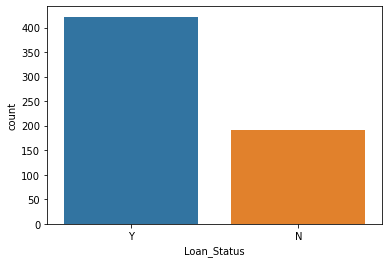

In [20]:
sb.countplot(x='Loan_Status',data=df_train,)
plt.show()

<AxesSubplot:xlabel='Gender', ylabel='count'>

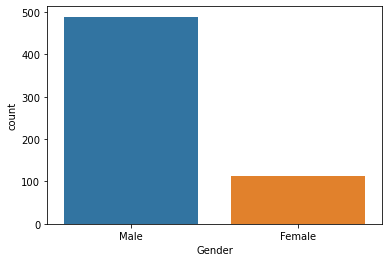

In [21]:
sb.countplot(x='Gender',data=df_train)

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

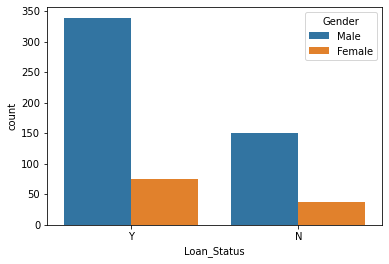

In [22]:
sb.countplot(x='Loan_Status',data=df_train,hue='Gender')

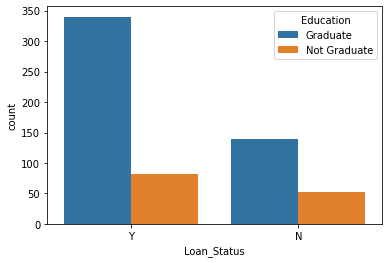

In [23]:
sb.countplot(x='Loan_Status',data=df_train,hue='Education')
plt.show()

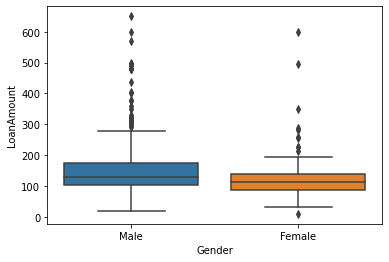

In [24]:
sb.boxplot(x='Gender',y='LoanAmount',data=df_train)
plt.show()

C:\Users\shebaz\Anaconda3\envs\tf_env\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


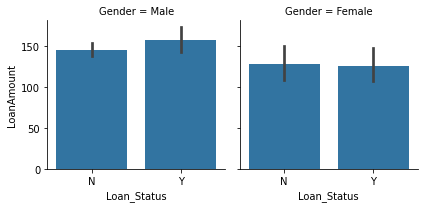

In [25]:
fg = sb.FacetGrid(df_train, col='Gender')
fg.map(sb.barplot, 'Loan_Status', 'LoanAmount' )
plt.show()

C:\Users\shebaz\Anaconda3\envs\tf_env\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


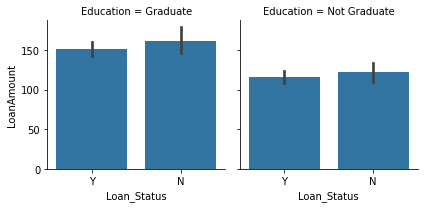

In [26]:
fg = sb.FacetGrid(df_train,col='Education')
fg.map(sb.barplot,'Loan_Status','LoanAmount')
plt.show()

# Data Preprocessing

define pipelines

In [27]:
cat_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(strategy=('most_frequent'))),
                       ('one_hot_encoder',OneHotEncoder(sparse=False))])
num_trans = Pipeline(steps=[('iterative_imputer',IterativeImputer())])

In [28]:
cat_train_df,numeric_train_df = split_categ_numer(x)

cat_train_features = cat_train_df.columns
num_train_features = numeric_train_df.columns

In [29]:
preprocessor = ColumnTransformer(
    transformers = [('num',num_trans,num_train_features),
                    ('cat',cat_trans,cat_train_features)])

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=70,random_state=42)

In [31]:
lb = LabelEncoder()
y_train = pd.Series(lb.fit_transform(y_train))
y_test = pd.Series(lb.transform(y_test))

# Baseline model

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [33]:
rf = Pipeline(steps=[('preprocessor',preprocessor),
                      ('classifier',RandomForestClassifier())])

In [34]:
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
print("Train set score: '",rf.score(x_train,y_train))
print("Test set score: '", accuracy_score(y_test,y_pred))

Train set score: ' 1.0
Test set score: ' 0.7113970588235294


# Modeling

In [35]:
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
]
scors = []
for classifier in classifiers:
    pipe = Pipeline([('preprocessor',preprocessor),
                    ('classifier',classifier)])
    pipe.fit(x_train,y_train)
    scors.append(pipe.score(x_test,y_test))
    

In [36]:
scors

[0.6691176470588235,
 0.6819852941176471,
 0.7279411764705882,
 0.7389705882352942,
 0.7242647058823529,
 0.6654411764705882]